In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from estimark.agents import (
    BequestWarmGlowLifeCyclePortfolioType,
    PortfolioLifeCycleConsumerType,
    WealthPortfolioLifeCycleConsumerType,
)
from estimark.estimation import get_weighted_moments
from estimark.parameters import age_mapping, init_calibration
from estimark.scf import scf_data
from estimark.snp import snp_data_full

#results_dir = "../../content/tables/TRP/"  # This is AEL's
results_dir = "../estimark/content/tables/min/" # This is MNW's

In [2]:
csv_file_path = results_dir + "PortfolioUSE2_estimate_results.csv"
res = pd.read_csv(csv_file_path, header=None)
res = res.set_index(res.columns[0])[res.columns[1]].to_dict()

In [3]:
portfolio_agent = PortfolioLifeCycleConsumerType(**init_calibration)
portfolio_agent.CRRA = float(res["CRRA"])
#portfolio_agent.DiscFac = float(res["DiscFac"])
portfolio_agent.CRRA, portfolio_agent.DiscFac

(8.039430602214585, 1.0)

In [4]:
csv_file_path = results_dir + "WarmGlowPortfolioUSE2_estimate_results.csv"
res = pd.read_csv(csv_file_path, header=None)
res = res.set_index(res.columns[0])[res.columns[1]].to_dict()

In [5]:
warmglow_agent = BequestWarmGlowLifeCyclePortfolioType(**init_calibration)
warmglow_agent.CRRA = float(res["CRRA"])
warmglow_agent.BeqCRRA = float(res["CRRA"])
#warmglow_agent.DiscFac = float(res["DiscFac"])
warmglow_agent.BeqFac = float(res["BeqFac"])
warmglow_agent.BeqShift = float(res["BeqShift"])
(
    warmglow_agent.CRRA,
    warmglow_agent.DiscFac,
    warmglow_agent.BeqFac,
    warmglow_agent.BeqShift,
)

(4.649418294387068, 1.0, 8415.764586702964, 2.5881868539438795)

In [6]:
csv_file_path = results_dir + "WealthPortfolioUSE2_estimate_results.csv"
res = pd.read_csv(csv_file_path, header=None)
res = res.set_index(res.columns[0])[res.columns[1]].to_dict()

In [7]:
trp_agent = WealthPortfolioLifeCycleConsumerType(**init_calibration)
trp_agent.CRRA = float(res["CRRA"])
trp_agent.WealthShare = float(res["WealthShare"])
#trp_agent.WealthShift = float(res["WealthShift"])
#trp_agent.DiscFac = float(res["DiscFac"])
trp_agent.CRRA, trp_agent.DiscFac, trp_agent.WealthShare, trp_agent.WealthShift

(4.8836870936886205, 1.0, 0.1595031693179906, 0.0)

In [8]:
agents = [portfolio_agent, warmglow_agent, trp_agent]

In [9]:
for agent in agents:
    agent.update()
    agent.solve()

    agent.track_vars = ["aNrm", "cNrm", "t_age", "bNrm", "Share"]
    # agent.LivPrb = [1.0] * portfolio_agent.T_cycle
    agent.T_sim = portfolio_agent.T_cycle
    agent.initialize_sim()
    history = agent.simulate()

    raw_data = {
        "Age": agent.history["t_age"].flatten() + 25,
        "nrmB": agent.history["bNrm"].flatten(),
        "nrmC": agent.history["cNrm"].flatten(),
        "Share": agent.history["Share"].flatten(),
    }

    Data = pd.DataFrame(raw_data)

    # Find the mean of each variable at every age
    agent.AgeMeans = Data.groupby(["Age"]).median().reset_index()

In [10]:
moments = get_weighted_moments(
    data=scf_data,
    variable="wealth_income_ratio",
    weights="weight",
    groups="age_group",
    mapping=age_mapping,
)
moments['(80,85]'] = [10.]
moments['(85,90]'] = [10.]
moments['(90,95]'] = [10.]

moments_values = []
for key in moments:
    moments_values.append([np.mean(age_mapping[key]), moments[key][0]])

moments_values = np.asarray(moments_values).T

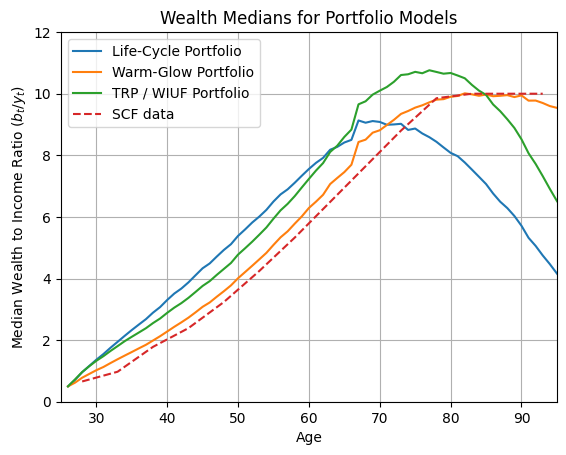

In [11]:
plt.figure()
plt.plot(
    portfolio_agent.AgeMeans.Age,
    portfolio_agent.AgeMeans.nrmB,
    label="Life-Cycle Portfolio",
    # alpha=0.5,  # make line more faded
    # linewidth=1,  # thinner line
)
plt.plot(
    warmglow_agent.AgeMeans.Age,
    warmglow_agent.AgeMeans.nrmB,
    label="Warm-Glow Portfolio",
    # alpha=0.5,  # make line more faded
    # linewidth=1,  # thinner line
)
plt.plot(
    trp_agent.AgeMeans.Age,
    trp_agent.AgeMeans.nrmB,
    label="TRP / WIUF Portfolio",
    # alpha=1,  # full color
    # linewidth=2,  # thicker line
)
plt.plot(
    moments_values[0],
    moments_values[1],
    label="SCF data",
    linestyle="--",
)
plt.legend()
plt.xlabel("Age")
plt.ylabel(r"Median Wealth to Income Ratio ($b_t/y_t$)")
plt.title("Wealth Medians for Portfolio Models")
plt.xlim(25, 95)
plt.ylim(0.0, 12.0)
plt.grid()
plt.savefig("median_wealth.pdf")
plt.savefig("median_wealth.svg")

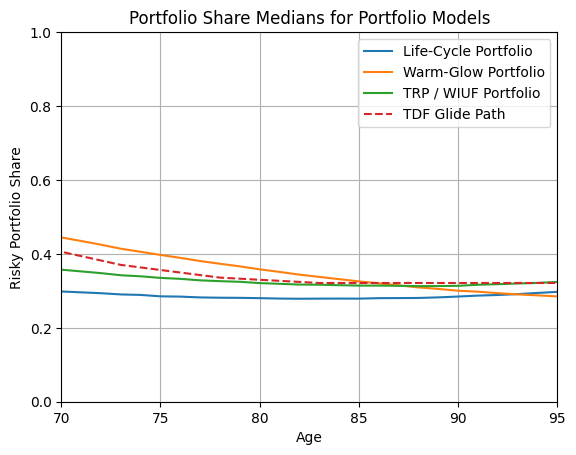

In [12]:
plt.figure()
plt.plot(
    portfolio_agent.AgeMeans.Age,
    portfolio_agent.AgeMeans.Share,
    label="Life-Cycle Portfolio",
    # alpha=0.5,  # make line more faded
    # linewidth=1,  # thinner line
)
plt.plot(
    warmglow_agent.AgeMeans.Age,
    warmglow_agent.AgeMeans.Share,
    label="Warm-Glow Portfolio",
    # alpha=0.5,  # make line more faded
    # linewidth=1,  # thinner line
)
plt.plot(
    trp_agent.AgeMeans.Age,
    trp_agent.AgeMeans.Share,
    label="TRP / WIUF Portfolio",
    # alpha=1,  # full color
    # linewidth=2,  # thicker line
)
plt.plot(
    snp_data_full["age"],
    snp_data_full["share"],
    label="TDF Glide Path",
    linestyle="--",
)
plt.legend()
plt.xlabel("Age")
plt.ylabel("Risky Portfolio Share")
plt.title("Portfolio Share Medians for Portfolio Models")
plt.xlim(70, 95)
plt.ylim(0.0, 1.0)
plt.grid()
plt.savefig("median_share.pdf")
plt.savefig("median_share.svg")